# Heart-stroke prediction

1. #3 (age): age in years 
2. #4 (sex): sex (1 = male; 0 = female) 
3. #9 (cp): cp: chest pain type | Value 0: typical angina | Value 1: atypical angina | Value 2: non-anginal pain | Value 3: asymptomatic 
4. #10 (trestbps): resting blood pressure (in mm Hg on admission to the hospital) 
5. #12 (chol): serum cholestoral in mg/dl 
6. #16 (fbs): (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false) 
7. #19 (restecg): resting electrocardiographic results | Value 0: normal | Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV) | Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria 
8. #32 (thalach): maximum heart rate achieved 
9. #38 (exang): exercise induced angina (1 = yes; 0 = no) 
10. #40 (oldpeak): ST depression induced by exercise relative to rest 
11. #41 (slope): the slope of the peak exercise ST segment | Value 1: upsloping | Value 2: flat | Value 3: downsloping 
12. #44 (ca): number of major vessels (0-3) colored by flourosopy 
13. #51 (thal): 3 = normal; 6 = fixed defect; 7 = reversable defect 
14. #58 (num) (the predicted attribute): Value 0: < 50% diameter narrowing | Value 1: > 50% diameter narrowing 

# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling as pp
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, log_loss, recall_score
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.cluster import KElbowVisualizer

In [2]:
!pip install pandas-profiling

In [3]:
%matplotlib inline

# Read in the Dataset

In [4]:
df = pd.read_csv('heart.csv')

In [5]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [6]:
df.shape

(303, 14)

# EDA

In [7]:
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
df.target.value_counts(normalize=True)

1    0.544554
0    0.455446
Name: target, dtype: float64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


# Data Pre-processing

In [10]:
df.duplicated().sum()

1

In [11]:
df.drop_duplicates(inplace=True)

In [12]:
df.duplicated().sum()

0

In [13]:
for col in df.select_dtypes('int'):
    print(df[col].value_counts(), '\n\n')

In [14]:
df['thal'].value_counts()

2    165
3    117
1     18
0      2
Name: thal, dtype: int64

In [15]:
# Drop 0's as they mean null
df.drop(df[df['thal']==0].index, inplace=True)

In [16]:
df['thal'].value_counts()

2    165
3    117
1     18
Name: thal, dtype: int64

<AxesSubplot:>

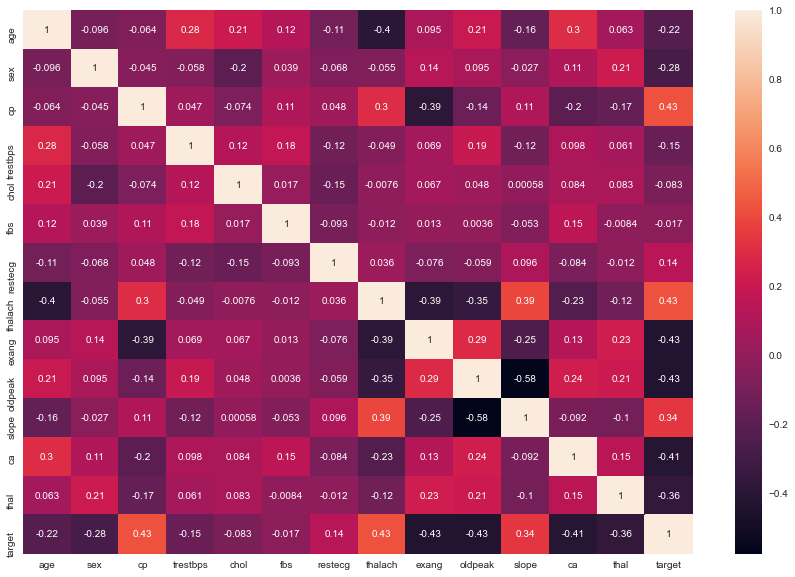

In [17]:
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(), annot=True)

In [18]:
X = df.drop('target', axis=1)

In [19]:
y = df.target

In [20]:
X

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3


In [21]:
y

0      1
1      1
2      1
3      1
4      1
      ..
298    0
299    0
300    0
301    0
302    0
Name: target, Length: 300, dtype: int64

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [23]:
scaler = MinMaxScaler()

In [24]:
X_train_scaled = scaler.fit_transform(X_train)

In [25]:
X_test_scaled = scaler.transform(X_test)

# Implement kNN

In [26]:
knn = KNeighborsClassifier(n_neighbors=1)

In [27]:
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=1)

In [28]:
knn_pred = knn.predict(X_test_scaled)

In [29]:
print(classification_report(y_test, knn_pred))

              precision    recall  f1-score   support

           0       0.75      0.85      0.80        39
           1       0.87      0.78      0.82        51

    accuracy                           0.81        90
   macro avg       0.81      0.82      0.81        90
weighted avg       0.82      0.81      0.81        90



<AxesSubplot:>

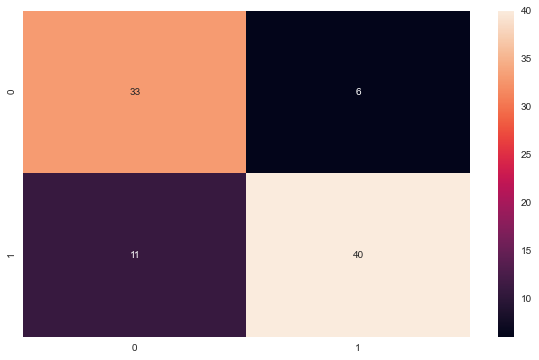

In [30]:
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, knn_pred), annot=True)

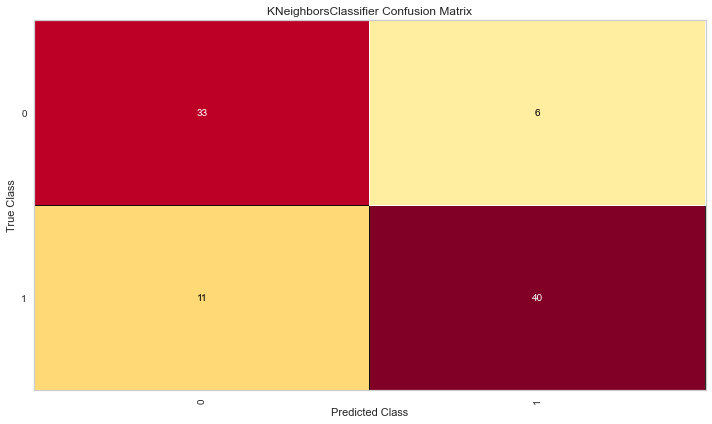

<AxesSubplot:title={'center':'KNeighborsClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [31]:
plt.figure(figsize=(10, 6))
cm = ConfusionMatrix(knn)
cm.fit(X_train_scaled, y_train)
cm.score(X_test_scaled, y_test)
cm.show()

In [32]:
error_rate = []
for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_scaled,y_train)
    pred_i = knn.predict(X_test_scaled)
    error_rate.append(1 - recall_score(y_test, pred_i))

Text(0, 0.5, 'Error Rate')

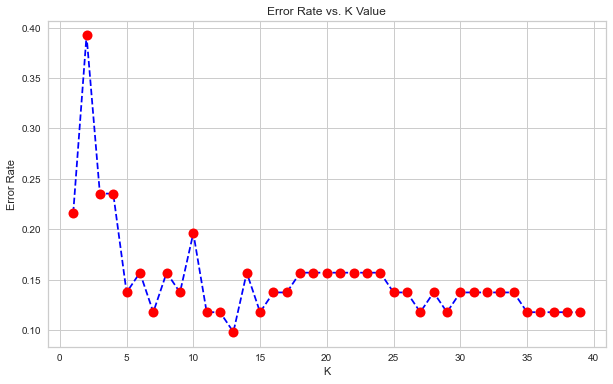

In [33]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [34]:
knn = KNeighborsClassifier(n_neighbors=13)

In [35]:
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=13)

In [36]:
knn_pred = knn.predict(X_test_scaled)

In [37]:
print(classification_report(y_test, knn_pred))

              precision    recall  f1-score   support

           0       0.86      0.77      0.81        39
           1       0.84      0.90      0.87        51

    accuracy                           0.84        90
   macro avg       0.85      0.84      0.84        90
weighted avg       0.85      0.84      0.84        90



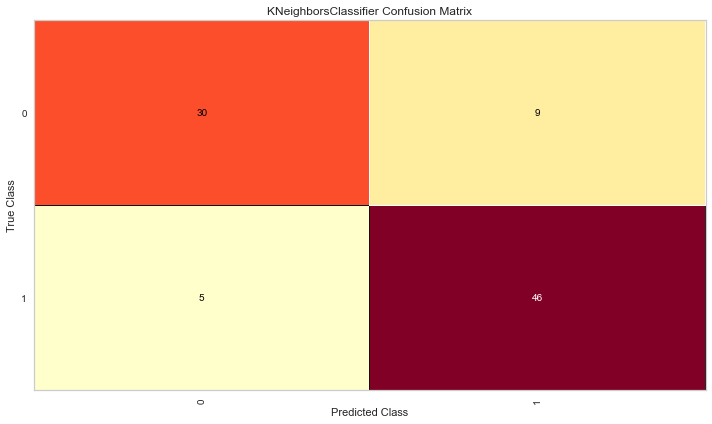

<AxesSubplot:title={'center':'KNeighborsClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [38]:
plt.figure(figsize=(10, 6))

cm = ConfusionMatrix(knn)
cm.fit(X_train_scaled, y_train)
cm.score(X_test_scaled, y_test)
cm.show()

In [39]:
scores = cross_validate(KNeighborsClassifier(n_neighbors=13), X_train_scaled, y_train, cv=10, n_jobs=-1, scoring=['recall'])

In [40]:
pd.DataFrame(scores)

,fit_time,score_time,test_recall
0,0.015624,0.000000,0.727273
1,0.000000,0.000000,0.727273
2,0.000000,0.000000,1.000000
3,0.000000,0.000000,0.818182
4,0.000000,0.000000,0.818182
5,0.000000,0.000000,0.818182
6,0.000000,0.015623,0.909091
7,0.015623,0.000000,0.909091
8,0.000000,0.000000,0.666667
9,0.000000,0.000000,0.916667


In [41]:
pd.DataFrame(scores)['test_recall'].mean()

0.831060606060606

In [42]:
grid_params = {'weights':['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'p':[1, 2], 'leaf_size': [20, 25, 30, 35, 40, 45],
              'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 15, 17], 'metric': ['minkowski', 'manhattan', 'euclidean']}

In [43]:
cv = GridSearchCV(KNeighborsClassifier(n_jobs=-1), param_grid=grid_params, n_jobs=-1, verbose=1, scoring='recall')

In [44]:
cv.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 3456 candidates, totalling 17280 fits


GridSearchCV(estimator=KNeighborsClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [20, 25, 30, 35, 40, 45],
                         'metric': ['minkowski', 'manhattan', 'euclidean'],
                         'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 15,
                                         17],
                         'p': [1, 2], 'weights': ['uniform', 'distance']},
             scoring='recall', verbose=1)

In [45]:
cv.best_score_

0.883399209486166

In [46]:
cv.best_params_

{'algorithm': 'auto',
 'leaf_size': 20,
 'metric': 'minkowski',
 'n_neighbors': 15,
 'p': 1,
 'weights': 'distance'}

In [47]:
knn_pred = cv.predict(X_test_scaled)

In [48]:
print(classification_report(y_test, knn_pred))

              precision    recall  f1-score   support

           0       0.86      0.79      0.83        39
           1       0.85      0.90      0.88        51

    accuracy                           0.86        90
   macro avg       0.86      0.85      0.85        90
weighted avg       0.86      0.86      0.85        90



In [49]:
knn = KNeighborsClassifier(leaf_size=20, p=1, weights='distance', n_neighbors=15)

In [50]:
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(leaf_size=20, n_neighbors=15, p=1, weights='distance')

In [51]:
knn_pred = knn.predict(X_test_scaled)

In [52]:
scores = cross_val_score(knn, X_train_scaled, y_train, scoring='recall', cv=10, n_jobs=-1)

In [53]:
pd.DataFrame(scores).mean()

0    0.875758
dtype: float64

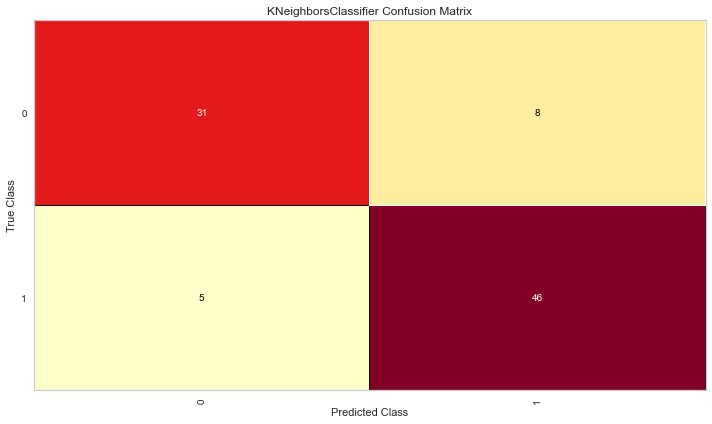

<AxesSubplot:title={'center':'KNeighborsClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [54]:
plt.figure(figsize=(10, 6))
cm = ConfusionMatrix(knn)
cm.fit(X_train_scaled, y_train)
cm.score(X_test_scaled, y_test)
cm.show()

In [55]:
knn_recall = recall_score(y_test, knn_pred)

In [56]:
knn_recall

0.9019607843137255

# Logistic Regression

In [57]:
log_model = LogisticRegression(n_jobs=-1)

In [58]:
log_model.fit(X_train_scaled, y_train)

LogisticRegression(n_jobs=-1)

In [59]:
log_pred = log_model.predict(X_test_scaled)

In [60]:
print(classification_report(y_test, log_pred))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82        39
           1       0.86      0.86      0.86        51

    accuracy                           0.84        90
   macro avg       0.84      0.84      0.84        90
weighted avg       0.84      0.84      0.84        90



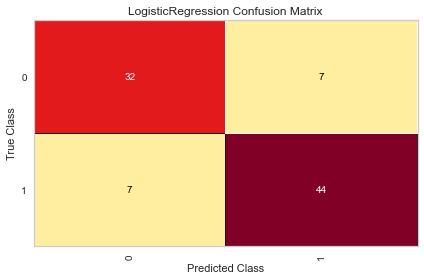

<AxesSubplot:title={'center':'LogisticRegression Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [61]:
cm = ConfusionMatrix(log_model)
cm.fit(X_train_scaled, y_train)
cm.score(X_test_scaled, y_test)
cm.show()

In [62]:
scores = cross_validate(log_model, X_train_scaled, y_train, scoring='recall', cv=10, n_jobs=-1)

In [63]:
pd.DataFrame(scores)

,fit_time,score_time,test_score
0,0.031250,0.000000,0.818182
1,0.031250,0.000000,0.909091
2,0.031250,0.000000,1.000000
3,0.031250,0.000000,0.818182
4,0.015623,0.000000,0.909091
5,0.015623,0.000000,0.636364
6,0.015623,0.015623,1.000000
7,0.015623,0.000000,0.909091
8,0.020622,0.013086,0.666667
9,0.004998,0.000000,0.916667


In [64]:
pd.DataFrame(scores)['test_score'].mean()

0.8583333333333334

In [65]:
log_recall = recall_score(y_test, log_pred)

In [66]:
log_recall

0.8627450980392157

# SVClassifier

In [67]:
sv_model = SVC()

In [68]:
sv_model.fit(X_train_scaled, y_train)

SVC()

In [69]:
sv_pred = sv_model.predict(X_test_scaled)

In [70]:
print(classification_report(y_test, sv_pred))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        39
           1       0.92      0.92      0.92        51

    accuracy                           0.91        90
   macro avg       0.91      0.91      0.91        90
weighted avg       0.91      0.91      0.91        90



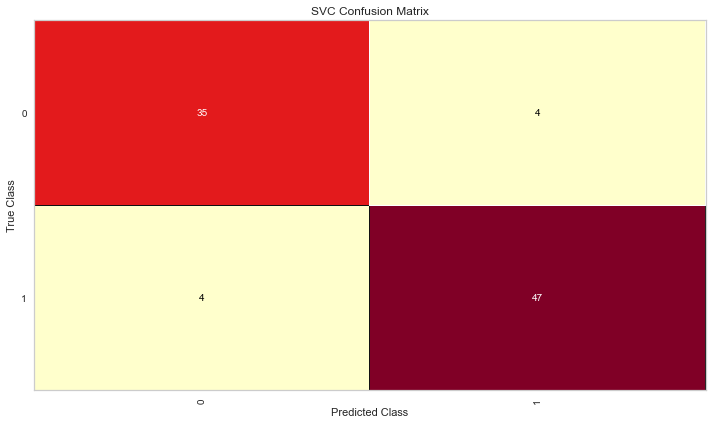

<AxesSubplot:title={'center':'SVC Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [71]:
plt.figure(figsize=(10, 6))
cm = ConfusionMatrix(sv_model)
cm.fit(X_train_scaled, y_train)
cm.score(X_test_scaled, y_test)
cm.show()

In [72]:
scores = cross_validate(sv_model, X_train_scaled, y_train, cv=10, n_jobs=-1, scoring='recall')

In [73]:
pd.DataFrame(scores)

,fit_time,score_time,test_score
0,0.007730,0.002998,0.636364
1,0.008730,0.001998,0.818182
2,0.003997,0.003000,0.909091
3,0.004997,0.005997,0.818182
4,0.003998,0.002999,0.909091
5,0.003996,0.001999,0.545455
6,0.003998,0.002998,0.909091
7,0.002998,0.002997,0.909091
8,0.003998,0.000999,0.916667
9,0.003997,0.002000,0.916667


In [74]:
pd.DataFrame(scores)['test_score'].mean()

0.8287878787878789

In [75]:
grid_param = {'C':[0.1, 0.3, 0.5, 0.7, 1, 1.5, 2, 2.5, 3],
             'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
             'degree': [1, 2, 3, 4],
             'gamma':[0.1, 0.3, 0.5, 0.7, 1, 1.5, 2, 2.5, 3, 'scale', 'auto'],
             'random_state':[42]}

In [76]:
cv = GridSearchCV(SVC(random_state=42), param_grid=grid_param, n_jobs=-1, scoring='recall')

In [77]:
cv.fit(X_train_scaled, y_train)

GridSearchCV(estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'C': [0.1, 0.3, 0.5, 0.7, 1, 1.5, 2, 2.5, 3],
                         'degree': [1, 2, 3, 4],
                         'gamma': [0.1, 0.3, 0.5, 0.7, 1, 1.5, 2, 2.5, 3,
                                   'scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                         'random_state': [42]},
             scoring='recall')

In [78]:
cv.best_score_

1.0

In [79]:
cv.best_params_

{'C': 0.1, 'degree': 1, 'gamma': 0.1, 'kernel': 'poly', 'random_state': 42}

In [80]:
cv.best_estimator_

SVC(C=0.1, degree=1, gamma=0.1, kernel='poly', random_state=42)

In [81]:
sv_pred = cv.predict(X_test_scaled)

In [82]:
print(classification_report(y_test, sv_pred))

              precision    recall  f1-score   support

           0       1.00      0.23      0.38        39
           1       0.63      1.00      0.77        51

    accuracy                           0.67        90
   macro avg       0.81      0.62      0.57        90
weighted avg       0.79      0.67      0.60        90



In [83]:
svc_tuned = SVC(C=0.1, degree=1, gamma=0.1, kernel='poly', random_state=42)

In [84]:
scores = cross_validate(svc_tuned, X_train_scaled, y_train, cv=10, n_jobs=-1, scoring='recall')

In [85]:
pd.DataFrame(scores)

,fit_time,score_time,test_score
0,0.015612,0.0,1.0
1,0.015612,0.0,1.0
2,0.015612,0.0,1.0
3,0.000000,0.0,1.0
4,0.000000,0.0,1.0
5,0.000000,0.0,1.0
6,0.000000,0.0,1.0
7,0.015624,0.0,1.0
8,0.015624,0.0,1.0
9,0.000000,0.0,1.0


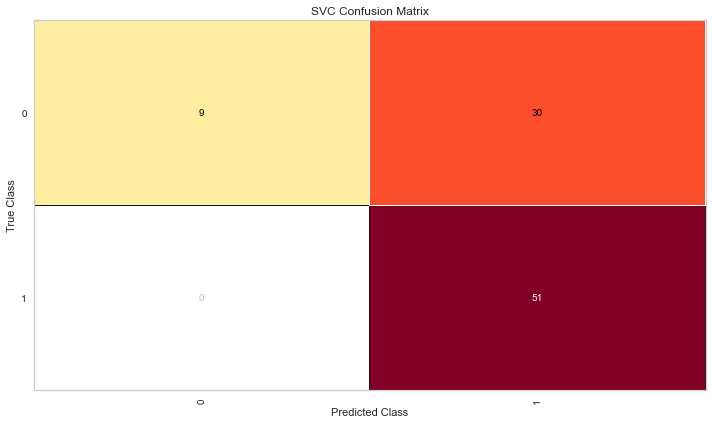

<AxesSubplot:title={'center':'SVC Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [86]:
plt.figure(figsize=(10, 6))
cm = ConfusionMatrix(svc_tuned)
cm.fit(X_train_scaled, y_train)
cm.score(X_test_scaled, y_test)
cm.show()

In [87]:
sv_recall = recall_score(y_test, sv_pred)

In [88]:
sv_recall

1.0

# Visually Compare Model Scores

In [89]:
plt.figure(figsize=(10, 6))

rec_df = pd.DataFrame({'knn_recall_score': knn_recall,
              'support_vector_recall_score': sv_recall,
              'log_reg_recall_score': log_recall}, index=[0])

<Figure size 720x432 with 0 Axes>

In [90]:
rec_df

,knn_recall_score,support_vector_recall_score,log_reg_recall_score
0,0.901961,1.0,0.862745


<AxesSubplot:>

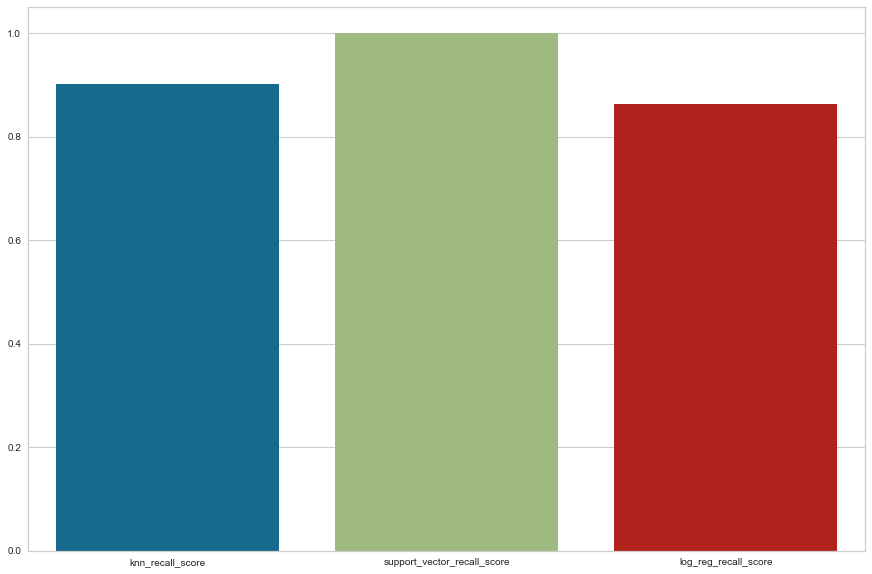

In [91]:
plt.figure(figsize=(15, 10))
sns.barplot(x=rec_df.columns, y=rec_df.iloc[0].values)